In [18]:
import json
import pandas as pd
from pathlib import Path
from typing import Any, Dict, List

# =========================
# CONFIGURATION
# =========================
DATASETS = {
    "scopus_2018_2023": {
        "input_dir": Path("ScopusData2018-2023"),
        "output_file": Path("data/scopus_author_affiliation_2018_2023.csv")
    }
}

Path("data").mkdir(exist_ok=True)

# =========================
# SAFE RECURSIVE SEARCH (FIND ALL)
# =========================
def find_all_keys(data: Any, target_key: str, found=None):
    if found is None:
        found = []

    if isinstance(data, dict):
        for key, value in data.items():
            if key == target_key:
                found.append(value)
            find_all_keys(value, target_key, found)

    elif isinstance(data, list):
        for item in data:
            find_all_keys(item, target_key, found)

    return found


# =========================
# FIELD EXTRACTORS
# =========================
def extract_paper_id(core: Dict[str, Any]) -> str:
    return (
        core.get("eid")
        or core.get("ce:pii")
        or core.get("pii")
        or core.get("dc:identifier")
        or "Unknown ID"
    )


def extract_title(core: Dict[str, Any]) -> str:
    return core.get("dc:title") or core.get("title") or "Unknown Title"


def extract_date(core: Dict[str, Any]) -> str:
    return core.get("prism:coverDate") or core.get("date-text") or "Unknown Date"


def normalize_list(x):
    if isinstance(x, list):
        return x
    if isinstance(x, dict):
        return [x]
    return []


def extract_affiliation_info(group: Dict[str, Any]) -> Dict[str, str]:
    aff = group.get("affiliation", {})

    aff_name = "Unknown University"

    orgs = aff.get("organization", [])
    if isinstance(orgs, list) and len(orgs) > 0:
        aff_name = orgs[-1].get("$", aff_name)
    elif isinstance(orgs, dict):
        aff_name = orgs.get("$", aff_name)
    elif "affilname" in aff:
        aff_name = aff["affilname"]

    country = aff.get("country") or aff.get("affiliation-country") or "Unknown"
    aff_id = aff.get("@afid", "")

    return {
        "Affiliation": aff_name,
        "Affiliation_ID": aff_id,
        "Country": country
    }


# =========================
# EXTRACTION ENGINE
# =========================
def process_dataset(name: str, cfg: Dict[str, Path]):

    input_dir = cfg["input_dir"]
    output_file = cfg["output_file"]

    print(f"\nProcessing Dataset: {name}")
    print(f"Input:  {input_dir.resolve()}")
    print(f"Output: {output_file.resolve()}")

    flat_data: List[Dict[str, Any]] = []
    files_opened = 0
    files_skipped = 0

    # IMPORTANT CHANGE: OPEN *ALL* FILES, NOT JUST *.json
    for file in input_dir.rglob("*"):
        if file.is_dir():
            continue

        try:
            with open(file, "r", encoding="utf-8") as f:
                data = json.load(f)  # will fail if not JSON

            files_opened += 1

            # --- Core data ---
            cores = find_all_keys(data, "coredata")
            if not cores:
                files_skipped += 1
                continue
            core = cores[0]

            paper_id = extract_paper_id(core)
            paper_title = extract_title(core)
            paper_date = extract_date(core)

            # --- Author groups ---
            author_groups = find_all_keys(data, "author-group")
            if not author_groups:
                files_skipped += 1
                continue

            for group_block in author_groups:
                groups = normalize_list(group_block)

                for group in groups:
                    aff_info = extract_affiliation_info(group)

                    authors = normalize_list(group.get("author"))

                    for auth in authors:
                        author_name = (
                            auth.get("ce:indexed-name")
                            or auth.get("authname")
                            or "Unknown Name"
                        )

                        flat_data.append({
                            "Paper_ID": paper_id,
                            "Title": paper_title,
                            "Date": paper_date,
                            "Author_Name": author_name,
                            **aff_info
                        })

        except json.JSONDecodeError:
            # Not a JSON file — silently skip
            continue
        except Exception as e:
            files_skipped += 1
            print(f"Skipped {file.name}: {e}")

    # =========================
    # FINAL OUTPUT
    # =========================
    print("\nSUMMARY")
    print(f"Opened JSON files: {files_opened}")
    print(f"Skipped (bad/no authors): {files_skipped}")
    print(f"Extracted rows: {len(flat_data)}")

    if flat_data:
        df = pd.DataFrame(flat_data)
        df.to_csv(output_file, index=False)
        print("-" * 60)
        print(f"SUCCESS! Saved to: {output_file.resolve()}")
        print(df.head())
    else:
        print("ERROR: No valid author-group data found.")


# =========================
# ▶RUN ALL DATASETS
# =========================
for name, cfg in DATASETS.items():
    process_dataset(name, cfg)


Processing Dataset: scopus_2018_2023
Input:  /Users/cappi/Downloads/Final Project/ScopusData2018-2023
Output: /Users/cappi/Downloads/Final Project/data/scopus_author_affiliation_2018_2023.csv
Skipped .DS_Store: 'utf-8' codec can't decode byte 0xdb in position 1072: invalid continuation byte

SUMMARY
Opened JSON files: 20216
Skipped (bad/no authors): 1
Extracted rows: 1512846
------------------------------------------------------------
SUCCESS! Saved to: /Users/cappi/Downloads/Final Project/data/scopus_author_affiliation_2018_2023.csv
             Paper_ID                                              Title  \
0  2-s2.0-85114881247  Direct immunofluorescence staining patterns co...   
1  2-s2.0-85114881247  Direct immunofluorescence staining patterns co...   
2  2-s2.0-85114881247  Direct immunofluorescence staining patterns co...   
3  2-s2.0-85114881247  Direct immunofluorescence staining patterns co...   
4  2-s2.0-85114881247  Direct immunofluorescence staining patterns co...   

  

In [2]:
df = pd.read_csv("data/scopus_author_affiliation_2018_2023.csv")

print("Unique papers:", df["Paper_ID"].nunique())
print("Unique authors:", df["Author_Name"].nunique())
print("Unique institutions:", df["Affiliation"].nunique())
print("Unique countries:", df["Country"].nunique())

Unique papers: 20216
Unique authors: 66799
Unique institutions: 19334
Unique countries: 176


In [3]:
import numpy as np
import matplotlib.pyplot as plt

DATA_PATH = Path("data/scopus_author_affiliation_2018_2023.csv")
OUTPUT_DIR = Path("data")
OUTPUT_DIR.mkdir(exist_ok=True)

df = pd.read_csv(DATA_PATH)

print(df.shape)
df.head()

(1512846, 7)


,Paper_ID,Title,Date,Author_Name,Affiliation,Affiliation_ID,Country
0,2-s2.0-85114881247,Direct immunofluorescence staining patterns co...,2022-02-01,Rujitharanawong C.,Mahidol University,60199575.0,Thailand
1,2-s2.0-85114881247,Direct immunofluorescence staining patterns co...,2022-02-01,Tuchinda P.,Mahidol University,60199575.0,Thailand
2,2-s2.0-85114881247,Direct immunofluorescence staining patterns co...,2022-02-01,Chularojanamontri L.,Mahidol University,60199575.0,Thailand
3,2-s2.0-85114881247,Direct immunofluorescence staining patterns co...,2022-02-01,Pochanapan O.,Mahidol University,60199575.0,Thailand
4,2-s2.0-85114881247,Direct immunofluorescence staining patterns co...,2022-02-01,Nuttawong S.,Mahidol University,60199575.0,Thailand


In [4]:
# Standardize column names
df.columns = [c.strip().lower() for c in df.columns]

# Rename for convenience
df = df.rename(columns={
    "paper_id": "paper_id",
    "title": "title",
    "date": "date",
    "author_name": "author",
    "affiliation": "institution",
    "affiliation_id": "institution_id",
    "country": "country"
})

# Drop fully empty rows
df = df.dropna(how="all")

# Clean text fields
for col in ["title", "author", "institution", "country"]:
    df[col] = df[col].fillna("").astype(str).str.strip()

# Clean date → extract year
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year

# Keep valid year range
df = df[df["year"].between(2018, 2023)]

# Remove rows with no valid institution or paper_id
df = df[(df["paper_id"] != "") & (df["institution"] != "")]

df = df.reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1512846 entries, 0 to 1512845
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   paper_id        1512846 non-null  object        
 1   title           1512846 non-null  object        
 2   date            1512846 non-null  datetime64[ns]
 3   author          1512846 non-null  object        
 4   institution     1512846 non-null  object        
 5   institution_id  1505668 non-null  float64       
 6   country         1512846 non-null  object        
 7   year            1512846 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), object(5)
memory usage: 86.6+ MB


In [5]:
# Remove exact duplicate rows
before = len(df)
df = df.drop_duplicates()
after = len(df)

print(f"Removed {before - after} duplicate rows")

# One row = one author-institution-paper
df[["paper_id", "author", "institution"]].duplicated().sum()

Removed 14148 duplicate rows


1868

In [6]:
eda_summary = {
    "Total Rows": len(df),
    "Unique Papers": df["paper_id"].nunique(),
    "Unique Authors": df["author"].nunique(),
    "Unique Institutions": df["institution"].nunique(),
    "Unique Countries": df["country"].nunique(),
    "Year Range": (df["year"].min(), df["year"].max())
}

pd.Series(eda_summary)

Total Rows                  1498698
Unique Papers                 20216
Unique Authors                66799
Unique Institutions           19334
Unique Countries                176
Year Range             (2018, 2023)
dtype: object

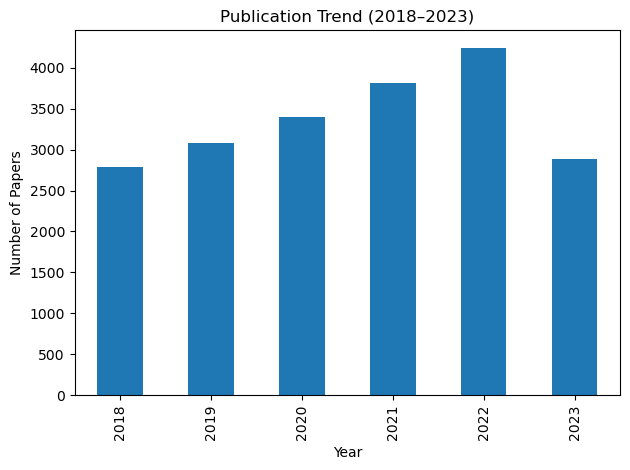

In [7]:
pub_trend = df.drop_duplicates("paper_id")["year"].value_counts().sort_index()

plt.figure()
pub_trend.plot(kind="bar")
plt.xlabel("Year")
plt.ylabel("Number of Papers")
plt.title("Publication Trend (2018–2023)")
plt.tight_layout()
plt.show()

/var/folders/w9/sp6srkdj28g1c4gzgkn90qd80000gn/T/ipykernel_23011/2456918520.py:7: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


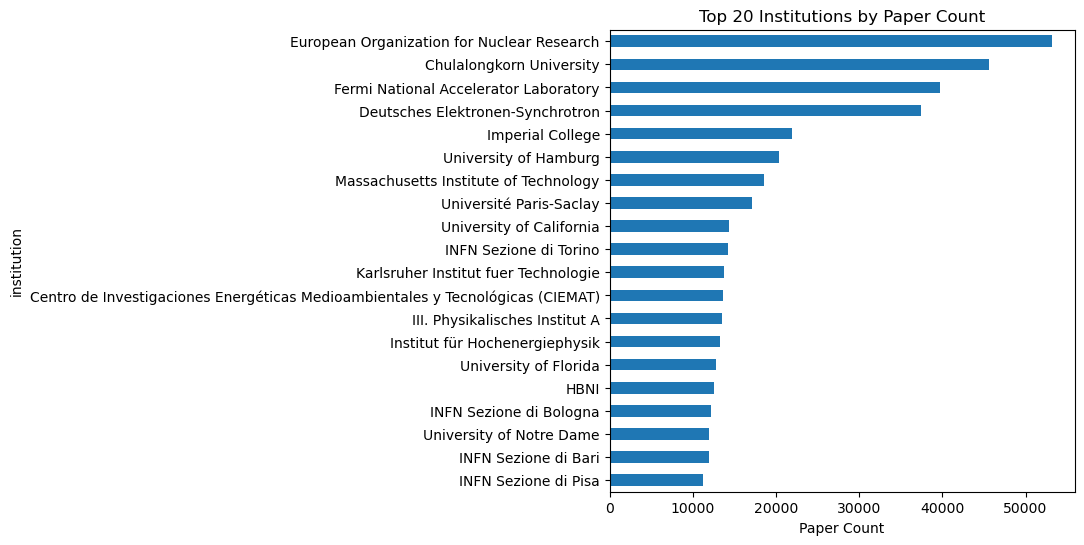

In [8]:
top_institutions = df["institution"].value_counts().head(20)

plt.figure(figsize=(6, 6))
top_institutions.sort_values().plot(kind="barh")
plt.title("Top 20 Institutions by Paper Count")
plt.xlabel("Paper Count")
plt.tight_layout()
plt.show()

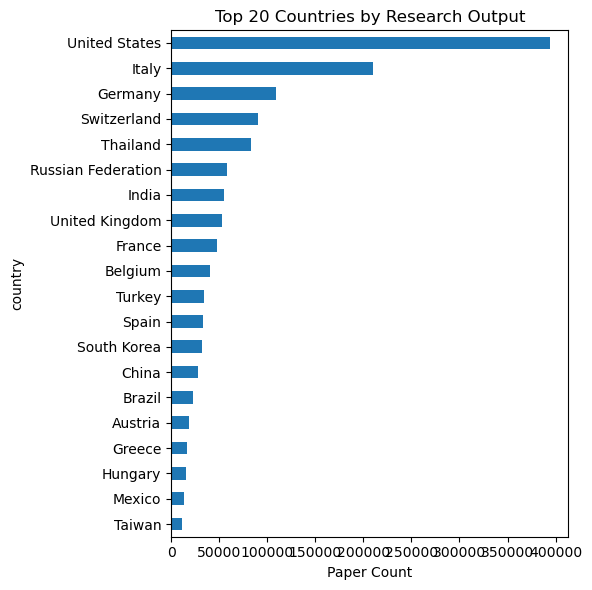

In [9]:
country_output = df["country"].value_counts().head(20)

plt.figure(figsize=(6, 6))
country_output.sort_values().plot(kind="barh")
plt.title("Top 20 Countries by Research Output")
plt.xlabel("Paper Count")
plt.tight_layout()
plt.show()

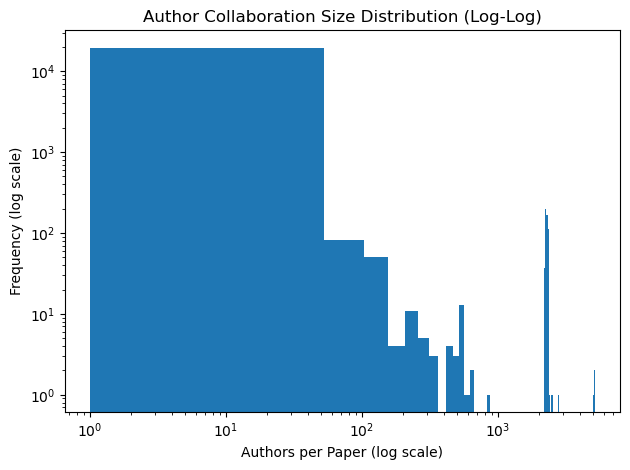

In [10]:
authors_per_paper = df.groupby("paper_id")["author"].nunique()

plt.figure()
plt.hist(authors_per_paper, bins=100)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Authors per Paper (log scale)")
plt.ylabel("Frequency (log scale)")
plt.title("Author Collaboration Size Distribution (Log-Log)")
plt.tight_layout()
plt.show()

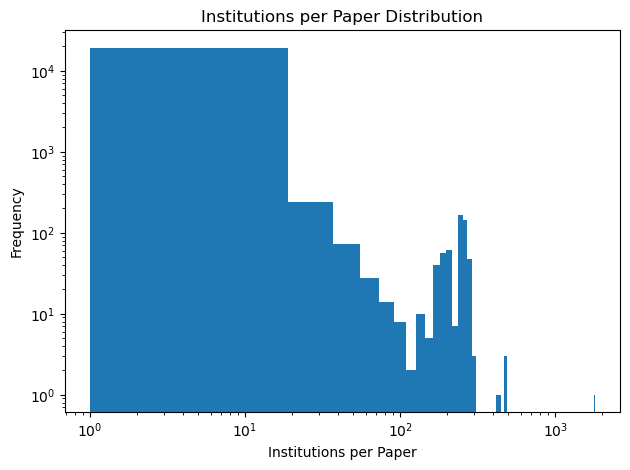

In [11]:
insts_per_paper = df.groupby("paper_id")["institution"].nunique()

plt.figure()
insts_per_paper.plot(kind="hist", bins=100)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Institutions per Paper")
plt.ylabel("Frequency")
plt.title("Institutions per Paper Distribution")
plt.tight_layout()
plt.show()

In [12]:
inst_paper = (
    df.groupby(["paper_id", "institution", "year", "country"])
      .size()
      .reset_index(name="author_count")
)

inst_paper.to_csv(OUTPUT_DIR / "institution_paper_clean.csv", index=False)

In [13]:
inst_year = (
    inst_paper.groupby(["institution", "year"])
    .agg({
        "paper_id": "nunique",
        "author_count": "sum"
    })
    .reset_index()
    .rename(columns={"paper_id": "num_papers"})
)

inst_year.to_csv(OUTPUT_DIR / "institution_year_output.csv", index=False)

In [14]:
country_year = (
    inst_paper.groupby(["country", "year"])["paper_id"]
    .nunique()
    .reset_index(name="num_papers")
)

country_year.to_csv(OUTPUT_DIR / "country_year_output.csv", index=False)

In [15]:
from itertools import combinations

edges = []

for paper_id, group in df.groupby("paper_id"):
    insts = group["institution"].unique()
    
    if len(insts) > 1:
        for a, b in combinations(insts, 2):
            edges.append((a, b))

edge_df = pd.DataFrame(edges, columns=["source", "target"])
edge_df = edge_df.value_counts().reset_index(name="weight")

edge_df.to_csv(OUTPUT_DIR / "institution_collaboration_edges.csv", index=False)

In [19]:
DATA_DIR = Path("data")

FILES = [
    "institution_ai_summary.csv",
    "institution_year_output.csv",
    "institution_collaboration_edges.csv"
]

bad_values = ['"', "''", "'", '""', 'None', 'nan', 'NaN', 'NULL', '']

for file in FILES:
    path = DATA_DIR / file
    if not path.exists():
        print(f"Skipped {file} (not found)")
        continue

    df = pd.read_csv(path)

    # Clean institution columns safely
    for col in df.columns:
        if "institution" in col.lower() or col in ["source", "target"]:
            df[col] = (
                df[col]
                .astype(str)
                .str.strip()
                .replace(bad_values, pd.NA)
            )

    # Drop rows with bad institutions
    if "institution" in df.columns:
        df = df.dropna(subset=["institution"])

    if "source" in df.columns and "target" in df.columns:
        df = df.dropna(subset=["source", "target"])

    df.to_csv(path, index=False)
    print(f"Cleaned: {file}")

print("All ghost institutions removed.")

Cleaned: institution_ai_summary.csv
Cleaned: institution_year_output.csv
Cleaned: institution_collaboration_edges.csv
All ghost institutions removed.


In [21]:
# ================================
# FINAL MASTER INSTITUTION CLEANER 
# ================================

import re

DATA_DIR = Path("data")

FILES_TO_CLEAN = [
    "institution_year_output.csv",
    "institution_collaboration_edges.csv",
    "institution_ai_summary.csv"
]

# --- 1. NON-UNIVERSITY KEYWORDS (Hospital, Dept, Lab, Company etc.) ---
non_uni_keywords = [
    "department", "dept", "hospital", "medical center", "centre", "center",
    "clinic", "laboratory", "lab", "institute", "foundation",
    "company", "corp", "ltd", "limited", "research",
    "school of", "faculty of", "ministry", "agency",
    "psychiatric", "health", "medical", "clinic"
]

# --- 2. ROAD / ADDRESS / LOCATION KEYWORDS ---
road_keywords = [
    "road", "rd", "street", "st", "avenue", "ave", "boulevard", "blvd",
    "soi", "moo", "tambon", "amphoe", "district", "province",
    "city", "zip", "postal", "rue", "seoul", "thailand science park"
]

# --- 3. PURE ADDRESS / NUMERIC PATTERNS ---
address_patterns = [
    r"^\d+$",                  # pure numbers (10330)
    r"^\d+\s+\w+",             # number + word (10 Kent)
    r"\b\d{3,}\b",             # large numeric blocks
]

# --- 4. BAD SYMBOLS ---
bad_symbols_pattern = r'[&@#%$*{}[\]|<>~`+=_^"]'

combined_pattern = re.compile(
    "|".join(non_uni_keywords + road_keywords + address_patterns),
    re.IGNORECASE
)

for file in FILES_TO_CLEAN:
    path = DATA_DIR / file
    if not path.exists():
        print(f"Skipped {file} (not found)")
        continue

    df = pd.read_csv(path)

    # Detect institution-related columns
    inst_cols = [
        c for c in df.columns
        if "institution" in c.lower() or c in ["source", "target"]
    ]

    for col in inst_cols:
        # Standardize text
        df[col] = (
            df[col]
            .astype(str)
            .str.strip()
            .str.replace(bad_symbols_pattern, "", regex=True)
            .str.replace(r"\s+", " ", regex=True)
        )

        # Remove address-like / hospital / department / numeric garbage
        mask = df[col].str.contains(combined_pattern, na=False)
        removed = df.loc[mask, col].nunique()
        df = df[~mask]

        print(f"{file}: removed {removed} invalid entries from '{col}'")

        # Remove empty & ultra-short garbage values
        df = df[df[col].notna()]
        df = df[df[col].str.len() >= 4]

    df.to_csv(path, index=False)
    print(f"Fully cleaned: {file}")

print("MASTER CLEANING COMPLETE — only true university institutions remain.")

institution_year_output.csv: removed 0 invalid entries from 'institution'
Fully cleaned: institution_year_output.csv
institution_collaboration_edges.csv: removed 0 invalid entries from 'source'
institution_collaboration_edges.csv: removed 0 invalid entries from 'target'
Fully cleaned: institution_collaboration_edges.csv
institution_ai_summary.csv: removed 0 invalid entries from 'institution'
Fully cleaned: institution_ai_summary.csv
MASTER CLEANING COMPLETE — only true university institutions remain.
